# **IMPORT**

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import pandas as pd
import numpy as np
import keras as tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **DATA PREPROCESSING**

In [3]:
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/buah"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 buahnaga_busuk    jeruk_busuk	  pepaya_busuk	   pisang_busuk    rambutan_busuk
 buahnaga_matang   jeruk_matang   pepaya_matang    pisang_matang   rambutan_matang
 buahnaga_mentah   jeruk_mentah  'pepaya mentah'   pisang_mentah  'rambutan mentah'


In [4]:
dataset_dir=r"/content/drive/MyDrive/buah"


filepaths=[]
labels=[]
classlist=os.listdir(dataset_dir)

for classs in classlist:
    classpath=os.path.join(dataset_dir,classs)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(classs)

file_series= pd.Series(filepaths, name='filepaths')
label_series=pd.Series(labels, name='labels')
df=pd.concat([file_series, label_series], axis=1)

print (df['labels'].value_counts())

labels
pisang_busuk       564
pisang_matang      540
rambutan mentah    526
rambutan_busuk     513
jeruk_busuk        504
pepaya_matang      503
pisang_mentah      480
pepaya mentah      451
jeruk_matang       393
pepaya_busuk       387
rambutan_matang    368
jeruk_mentah       355
buahnaga_mentah    241
buahnaga_matang    235
buahnaga_busuk     217
Name: count, dtype: int64


In [5]:
train_split=.8
test_split=.1

dummy_split=test_split/(1-train_split)
train_dataframe, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_dataframe, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train data frame len: ', len(train_dataframe), '  test data frame len: ', len(test_dataframe), '  valid data frame len: ', len(valid_df))


train data frame len:  5021   test data frame len:  628   valid data frame len:  628


In [6]:
# Set image dimensions and batch size
height = 224
width = 224
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)

# Calculate test batch size and steps
length = len(test_dataframe)
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size:', test_batch_size, '  test steps:', test_steps)

test batch size: 4   test steps: 157


In [7]:
# Create ImageDataGenerators
gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_gen = gen.flow_from_dataframe(
    train_dataframe,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,

)

valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = gen.flow_from_dataframe(
    test_dataframe,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 5021 validated image filenames belonging to 15 classes.
Found 628 validated image filenames belonging to 15 classes.
Found 628 validated image filenames belonging to 15 classes.


In [8]:
classes = list(train_gen.class_indices.keys())
print(classes)
# print class
class_indices = train_gen.class_indices
class_count = len(classes)
print("Number of classes: ",class_indices)

['buahnaga_busuk', 'buahnaga_matang', 'buahnaga_mentah', 'jeruk_busuk', 'jeruk_matang', 'jeruk_mentah', 'pepaya mentah', 'pepaya_busuk', 'pepaya_matang', 'pisang_busuk', 'pisang_matang', 'pisang_mentah', 'rambutan mentah', 'rambutan_busuk', 'rambutan_matang']
Number of classes:  {'buahnaga_busuk': 0, 'buahnaga_matang': 1, 'buahnaga_mentah': 2, 'jeruk_busuk': 3, 'jeruk_matang': 4, 'jeruk_mentah': 5, 'pepaya mentah': 6, 'pepaya_busuk': 7, 'pepaya_matang': 8, 'pisang_busuk': 9, 'pisang_matang': 10, 'pisang_mentah': 11, 'rambutan mentah': 12, 'rambutan_busuk': 13, 'rambutan_matang': 14}


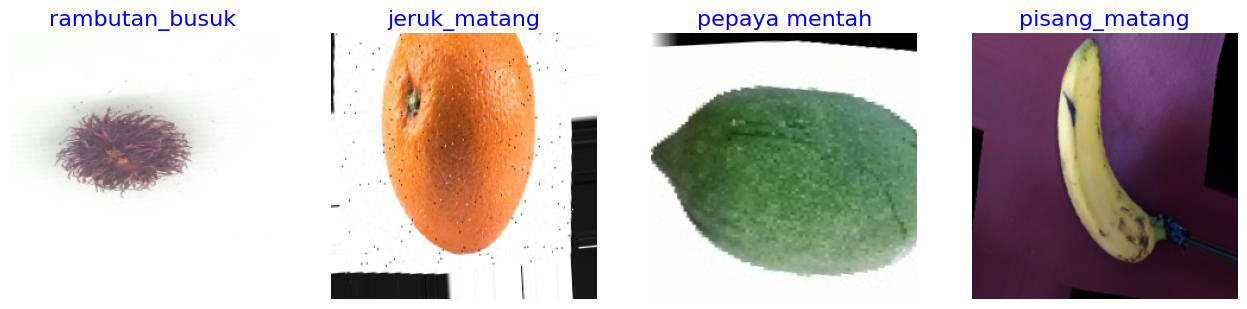

In [9]:
def show_image_samples(gen):
    test_dict = test_gen.class_indices
    classes = list(test_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 10:
        r = length
    else:
        r = 10
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

# Example usage
show_image_samples(test_gen)

# **TRANSFER LEARNING**

In [10]:
height = 224
width = 224
channels = 3

# Transfer Learning MobileNetV2
TL_model = tf.keras.applications.MobileNetV2(
    input_shape=(height, width, channels),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=tf.keras.layers.Input(shape=(height, width, channels)),
    pooling=None,
)



In [11]:
TL_model.trainable = False

In [12]:
TL_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
model_name = 'CIFRUIT'
print("Building model with", TL_model)
num_classes = len(train_gen.class_indices)
model = tf.keras.Sequential([
    TL_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


Building model with <Functional name=mobilenetv2_1.00_224, built=True>


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.


In [16]:


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit model with EarlyStopping callback
history = model.fit(
    x=train_gen,
    epochs=30,
    validation_data=valid_gen,
    callbacks=[early_stopping]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - accuracy: 0.5057 - loss: 1.5826 - val_accuracy: 0.9124 - val_loss: 0.3434
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.8253 - loss: 0.5054 - val_accuracy: 0.9220 - val_loss: 0.2372
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 382s 5s/step - accuracy: 0.8761 - loss: 0.3782 - val_accuracy: 0.9204 - val_loss: 0.2182
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.8923 - loss: 0.3238 - val_accuracy: 0.9459 - val_loss: 0.1687
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.9019 - loss: 0.2776 - val_accuracy: 0.9522 - val_loss: 0.1488
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.9105 - loss: 0.2672 - val_accuracy: 0.9427 - val_loss: 0.1626
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 0.9153 - loss: 0.2436 - val_accuracy: 0.9490 - val_loss: 0.1371
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - accuracy: 0.9243 - loss: 0.2123 - val_accuracy: 0.9395 - val_loss: 0.

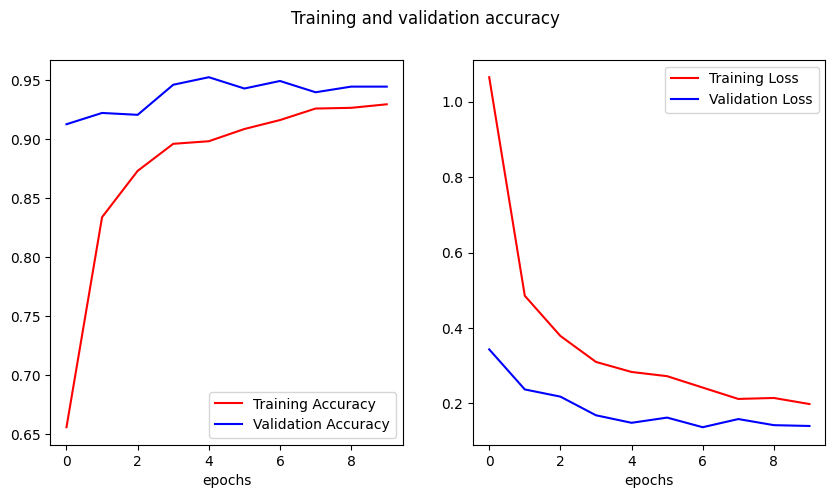

In [17]:
 # Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

# **SAVE MODEL**

In [18]:
CIFRUIT_SAVED_MODEL = "cifruit_saved_model"
tf.saved_model.save(model, CIFRUIT_SAVED_MODEL)

In [19]:
%%bash -s $CIFRUIT_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['inputs'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_inputs:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 15)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2024-12-02 12:43:28.479811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 12:43:28.502076: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 12:43:28.508548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 12:43:29.903341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
loaded = tf.saved_model.load(CIFRUIT_SAVED_MODEL)

print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'inputs': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')})
{'output_0': TensorSpec(shape=(None, 15), dtype=tf.float32, name='output_0')}


In [21]:
from google.colab import files
files.download('cifruit_saved_model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
!cp -r cifruit_saved_model "/content/drive/MyDrive"


In [23]:
!zip -r cifruit_saved_model.zip cifruit_saved_model/


  adding: cifruit_saved_model/ (stored 0%)
  adding: cifruit_saved_model/variables/ (stored 0%)
  adding: cifruit_saved_model/variables/variables.index (deflated 77%)
  adding: cifruit_saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: cifruit_saved_model/fingerprint.pb (stored 0%)
  adding: cifruit_saved_model/assets/ (stored 0%)
  adding: cifruit_saved_model/saved_model.pb (deflated 92%)


In [24]:
model.save('model_cifruit.h5')


In [25]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
model.save('/content/drive/My Drive/ColabModels/model_cifruit.h5')

# **CONVERT TO TFLITE**

In [27]:
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [28]:
from tensorflow.keras.models import load_model

In [29]:
model = load_model('model_cifruit.h5')

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set optimasi (opsional)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Menggunakan optimasi default (quantization)

# Konversi model
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
with open('model_cifruit.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpo3s1wken'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  132411995373264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411995352128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411995354240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411995347552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411995349840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411995355824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411994062912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411994063792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411995356704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411994063264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411994067

In [31]:
import numpy as np
import tensorflow as tf

# Load TFLite model dan alokasikan tensor
interpreter = tf.lite.Interpreter(model_path="model_cifruit.tflite")
interpreter.allocate_tensors()

# Mendapatkan input dan output tensor dari model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model pada data input acak
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inferensi
interpreter.invoke()

# Ambil output data
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[1.23794926e-02 8.22022464e-03 1.10096531e-03 3.59560922e-03
  7.59051442e-02 1.57909859e-02 7.61910997e-05 8.60399974e-04
  2.84594717e-04 4.08453838e-04 1.52336001e-01 1.04698256e-01
  9.60941761e-05 4.61717546e-01 1.62530065e-01]]


In [32]:
import shutil
shutil.make_archive("cifruit_saved_model", "zip", "cifruit_saved_model")


'/content/cifruit_saved_model.zip'

# **TEST**

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np

# Mapping kelas
class_mapping = {'jeruk_busuk': 0, 'jeruk_matang': 1, 'jeruk_mentah': 2, 'mangga_busuk': 3, 'mangga_matang': 4, 'mangga_mentah': 5, 'pepaya mentah': 6, 'pepaya_busuk': 7, 'pepaya_matang': 8, 'pisang_busuk': 9, 'pisang_matang': 10, 'pisang_mentah': 11, 'rambutan mentah': 12, 'rambutan_busuk': 13, 'rambutan_matang': 14}

# Fungsi untuk memprediksi gambar
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = list(class_mapping.keys())[list(class_mapping.values()).index(predicted_class_index)]
    confidence = predictions[0][predicted_class_index]

    return predicted_class, confidence

# Load model
model = tf.keras.models.load_model('/content/model_cifruit.h5')

# Contoh pengujian dengan gambar
image_path = '/content/pp.jpg'
predicted_class, confidence = predict_image(model, image_path)

# Output hasil prediksi
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: pisang_busuk
Confidence: 0.9770488
